In [1013]:
import warnings

warnings.filterwarnings("ignore")

In [1014]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [1015]:
train_data = pd.read_csv("./data/train_ctrUa4K.csv", index_col="Loan_ID")
test_data = pd.read_csv("./data/test_lAUu6dG.csv", index_col="Loan_ID")

In [1016]:
train_data.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
Loan_ID,,,,,,,,,,,,
LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [1017]:
train_data.shape, test_data.shape

((614, 12), (367, 11))

In [1018]:
train_data.isna().sum()

Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [1019]:
def plot_hist(df, col, size = (14,10)):
    
    plt.title("Distribution according to "+col+" values")
    ax = sns.countplot(data = df, x=col, hue = col)
    
    for p in ax.patches:
        
        if p.get_height()>0:
            ax.annotate(f'\n{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom', color='black', fontsize=12)

    plt.show()

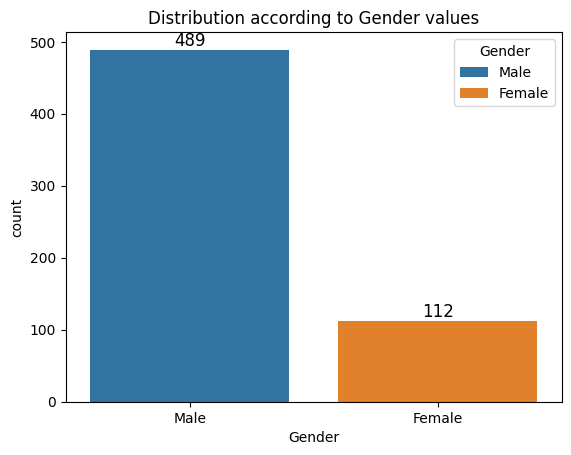

In [1020]:
plot_hist(train_data, "Gender")

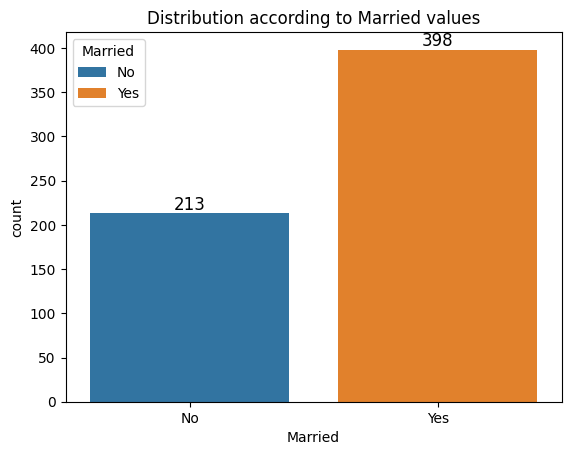

In [1021]:
plot_hist(train_data, "Married")

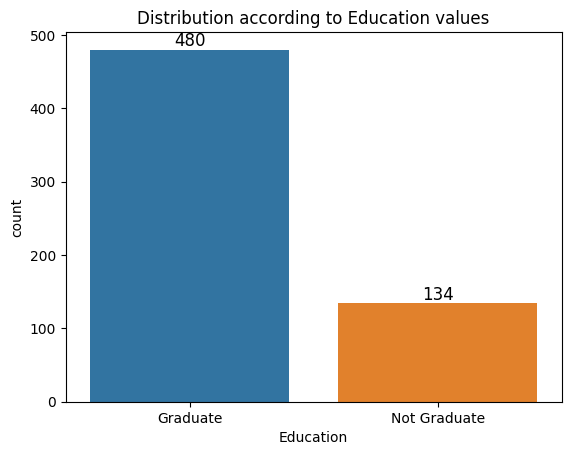

In [1022]:
plot_hist(train_data, "Education")

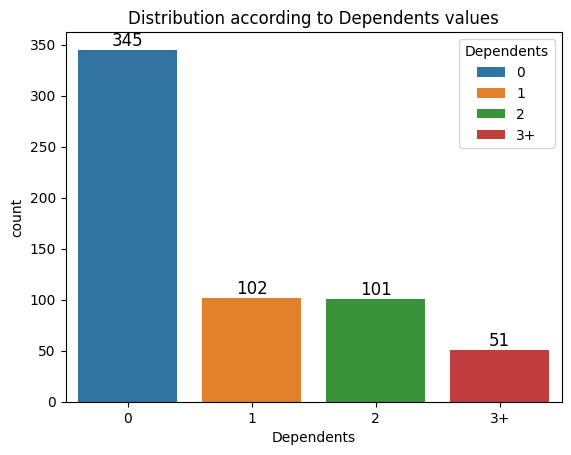

In [1023]:
plot_hist(train_data, "Dependents")

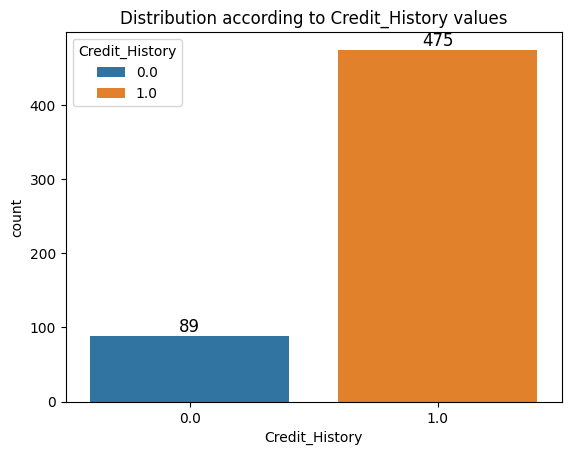

In [1024]:
plot_hist(train_data, "Credit_History")

## Missing values traitement

In [1025]:
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from imblearn.over_sampling import RandomOverSampler, SMOTE

In [1026]:
def select_missing_train_data(df, col_without_nan,col_with_nan):
    
    col_without_nan.append(col_with_nan)
    
    return df[col_without_nan]

def data_for_missing_model(df, target_index = 0):

    col_with_nan = list(train_data.columns[(train_data.isna().sum() != 0).values].values)
    col_without_nan = list(df.columns[(df.isna().sum() == 0).values].values)
    
    Gender_missing_data = select_missing_train_data(df, col_without_nan, col_with_nan[target_index])
    
    return Gender_missing_data

def binary_encoding(y):
    label_en = LabelEncoder()
    y_en = label_en.fit_transform(y)
    return y_en

def evaluate_model(model, X_test, y_test):
    # On prédit les valeurs de la variable cible pour les données de test
    y_pred = model.predict(X_test)

    # On calcule la matrice de confusion
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)

    # On calcule le rapport de classification

    report = classification_report(y_test, y_pred)
    print(report)
    return None

- ## Gender

In [1027]:
Test_missing_data[Test_missing_data[target_col].isna().iloc[:,0] == True]

,Married,Education,ApplicantIncome,CoapplicantIncome,Property_Area,Married
Loan_ID,,,,,,


In [1028]:
def create_missi_train_test_set(col_missing_data, col):

    if col == "Married":
        
        col_missing_data = col_missing_data.iloc[:,1:]
    
    miss_gender_train_set = col_missing_data[col_missing_data[col].isna()==False]
    miss_gender_test_set = col_missing_data[col_missing_data[col].isna()==True]
    
    return miss_gender_train_set, miss_gender_test_set

In [1029]:
def separate_X_to_y_and_encode(miss_gender_train_set, miss_gender_test_set):
    
    X_miss_gen_train ,y_miss_gen_train = miss_gender_train_set.iloc[:,:-1],miss_gender_train_set.iloc[:,-1]
    X_miss_gen_test = miss_gender_test_set.iloc[:,:-1]
    
    cate_col = X_miss_gen_train.select_dtypes(include="object").columns

    X_miss_gen_train_en = X_miss_gen_train.copy()
    X_miss_gen_test_en = X_miss_gen_test.copy()


    for col in cate_col:
        X_miss_gen_train_en[col] = binary_encoding(X_miss_gen_train[col])
        X_miss_gen_test_en[col] = binary_encoding(X_miss_gen_test[col])
        
    y_miss_gen_train_en = binary_encoding(y_miss_gen_train)
    
    return X_miss_gen_train_en, X_miss_gen_test_en, y_miss_gen_train_en

In [1030]:
def train_model(model, X, y, parameters, grid = False, balance = True):
    
    
    if balance:
        # Redressage l'échantillon train par oversampling
        oversampler = SMOTE(random_state=42)
        X, y = oversampler.fit_resample(X,y)
    
    model.fit(X, y)
    
    if grid:
        print("With gridsearch")
        param_grid = parameters

        model = GridSearchCV(estimator=model, param_grid=param_grid, cv=100, scoring='accuracy')
        
        model.fit(X, y)
    
    # Afficher les meilleurs paramètres
        best_params = model.best_params_
        best_score = model.best_score_
        print("Meilleurs paramètres :", best_params)# Meilleur paramètres
        print("Meilleur score : ", best_score) # Meilleur score

    return X, y, model

In [1031]:
def miss_value_treatment_pipeline(model, train_data, test_data, parameter , grid = False, balance = False, index_miss_target = 0):
    
    Gender_missing_data = data_for_missing_model(train_data, target_index = index_miss_target)
    Test_missing_data = data_for_missing_model(test_data, target_index = index_miss_target)
    target_col = Gender_missing_data.columns[-1]
    print("Target col : ", target_col)
    print("==="*30)
    print("\n Treatement of "+target_col+" missing values \n")
    print("==="*30)
    
    miss_gender_train_set, miss_gender_test_set = create_missi_train_test_set(Gender_missing_data, target_col)
    miss_Test_train_set, miss_Test_test_set = create_missi_train_test_set(Test_missing_data, target_col)
    
    X_miss_gen_train_en, X_miss_gen_test_en, y_miss_gen_train_en = separate_X_to_y_and_encode(miss_gender_train_set,
                                                                                              miss_gender_test_set
                                                                                              )
    XTest_train_en, XTest_test_en, y_Train = separate_X_to_y_and_encode(miss_Test_train_set, 
                                                                        miss_Test_test_set)
    if target_col not in ["Married","LoanAmount","Loan_Amount_Term"]:
        X_miss_gen_train_en_aug, y_miss_gen_train_en_aug, model_trained = train_model(model, 
                                                                                      X_miss_gen_train_en,
                                                                                      y_miss_gen_train_en, parameter, 
                                                                                      grid = grid, 
                                                                                      balance=balance)

        evaluate_model(model_trained, X_miss_gen_train_en_aug, y_miss_gen_train_en_aug)
    
    
        #For training data missing value solving
        y_predict = model_trained.predict(X_miss_gen_test_en)
    
        #X_miss_gen_test_en[target_col] = y_predict
        #X_miss_gen_train_en[target_col] = y_miss_gen_train_en

        #For testing data missing value solving
        X_miss_gen_train_en_aug, y_miss_gen_train_en_aug, model_trained = train_model(model,X_miss_gen_train_en,#.drop(columns=[target_col]),
                                                                                      y_miss_gen_train_en, parameter, 
                                                                                      grid = grid, 
                                                                                      balance=balance)
        y_predict_Test = model_trained.predict(XTest_test_en.drop(columns=["Married"]))
    
    else:
        
        if target_col == "Married":
            
            X_miss_gen_train_en_aug, y_miss_gen_train_en_aug, model_trained = train_model(model, 
                                                                                      X_miss_gen_train_en,
                                                                                      y_miss_gen_train_en, parameter, 
                                                                                      grid = grid, 
                                                                                      balance=balance)
    
            #For training data missing value solving
            y_predict = model_trained.predict(X_miss_gen_test_en)

            
            y_predict_Test = test_data[test_data[target_col].isna()==True][target_col].values
     
        if target_col == "LoanAmount":
            
            y_predict_Test = test_data[test_data.isna()[target_col]][target_col]
            
            #For training data missing value solving
            y_predict = train_data[train_data.isna()[target_col]==False][target_col]
        
        if target_col == "Loan_Amount_Term":
            
            y_predict_Test = test_data[test_data.isna()[target_col]][target_col]
            
            #For training data missing value solving
            y_predict = train_data[train_data.isna()[target_col]==False][target_col]
        
    XTest_test_en[target_col] = y_predict_Test
    XTest_train_en[target_col] = y_Train
    
    X_miss_gen_test_en[target_col] = y_predict
    X_miss_gen_train_en[target_col] = y_miss_gen_train_en
    
    
    df_Train = pd.concat([X_miss_gen_train_en, X_miss_gen_test_en], axis = 0)
    
    df_Test = pd.concat([XTest_train_en, XTest_test_en], axis = 0)
    
    df_Train["LoanAmount"] = train_data["LoanAmount"]
    df_Test["LoanAmount"] = test_data["LoanAmount"]
    
    df_Train["Loan_Amount_Term"] = train_data["Loan_Amount_Term"]
    df_Test["Loan_Amount_Term"] = test_data["Loan_Amount_Term"]
    
    return df_Train, df_Test

In [1032]:
lr_parameter = {
                'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                'penalty': ['l1', 'l2'],
                'max_iter': [100, 500, 1000, 10000]
                }
rf_parameter = {
                'n_estimators': [10, 20, 50, 100],
                'max_depth': [None, 1, 2, 3],
                'min_samples_split': [2, 5, 10, 50, 100],
                'min_samples_leaf': [1, 2, 4]
                }

In [1033]:
rf_model = RandomForestClassifier(random_state=42)
lr_model = LogisticRegression()

train_data_gen, Test_data_en = miss_value_treatment_pipeline(model,
                                                             train_data.drop(columns=["Loan_Status"]),
                                                             test_data,
                                                             parameter,
                                                             grid = False,
                                                             balance = False,
                                                             index_miss_target = 0
                                                            )

Target col :  Credit_History

 Treatement of Credit_History missing values 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       475
           1       1.00      1.00      1.00       475

    accuracy                           1.00       950
   macro avg       1.00      1.00      1.00       950
weighted avg       1.00      1.00      1.00       950



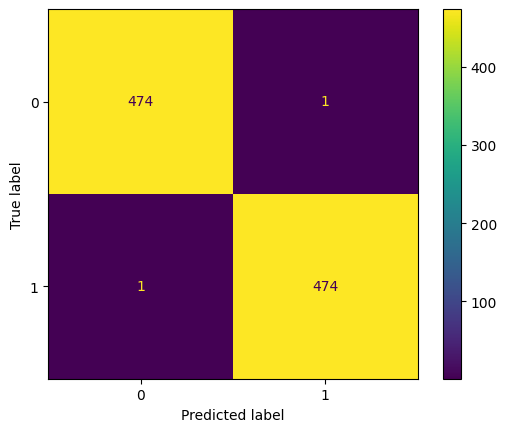

In [1034]:
train_data_gen = miss_value_treatment_pipeline(rf_model, 
                                               train_data.drop(columns=["Loan_Status"]), 
                                               test_data, 
                                               rf_parameter, 
                                               grid = False, 
                                               balance = True, 
                                               index_miss_target = 6)

In [1035]:
grid = False 
balance = True 
index_miss_target = 2
model = rf_model
parameter = rf_parameter

Target col :  Gender

 Treatement of Gender missing values 

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       489
           1       0.99      0.99      0.99       489

    accuracy                           0.99       978
   macro avg       0.99      0.99      0.99       978
weighted avg       0.99      0.99      0.99       978

Target col :  Married

 Treatement of Married missing values 

Target col :  Dependents

 Treatement of Dependents missing values 

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       345
           1       0.99      0.99      0.99       345
           2       0.99      0.99      0.99       345
           3       1.00      1.00      1.00       345

    accuracy                           0.99      1380
   macro avg       0.99      0.99      0.99      1380
weighted avg       0.99      0.99      0.99      1380

Target col :  Self_Employed

 Treatement of S

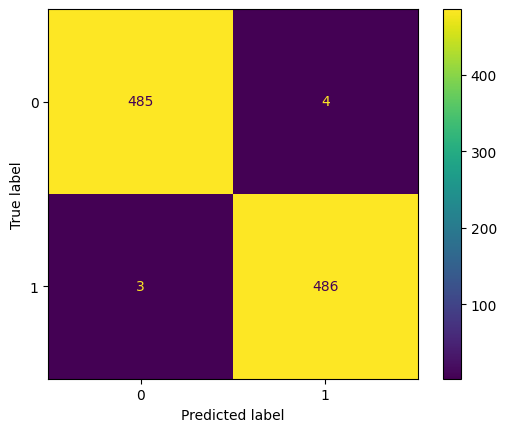

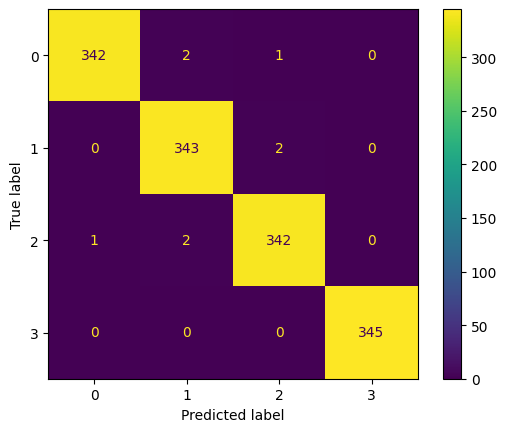

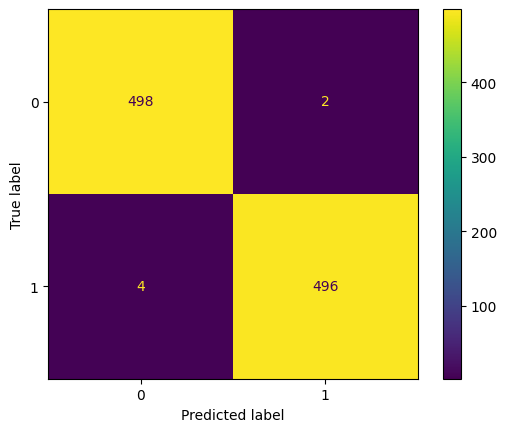

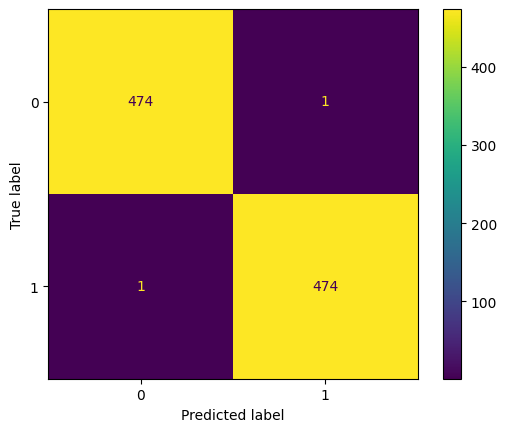

In [1036]:
cate_col_index = range(sum(train_data.isna().sum().values >0))
cate_col_index = [0,1,2,3,4,5,6]

def create_df(train_data, cate_col_index):

    df_tr = []
    df_te = []

    for col_index in cate_col_index:

        temp_train, temp_test = miss_value_treatment_pipeline(rf_model, 
                                                   train_data.drop(columns=["Loan_Status"]),
                                                   test_data, 
                                                   rf_parameter, 
                                                   grid, 
                                                   balance, 
                                                   index_miss_target = col_index)

        df_tr.append(temp_train)
        df_te.append(temp_test)

    
    train_df = pd.concat( df_tr, axis = 1)
    test_df = pd.concat( df_te, axis = 1)
    
    return train_df,test_df

train_df, test_df = create_df(train_data, cate_col_index)

In [1037]:
train_df.head(2)

,Education,ApplicantIncome,CoapplicantIncome,Property_Area,Gender,LoanAmount,Loan_Amount_Term,ApplicantIncome,CoapplicantIncome,Property_Area,...,Property_Area,Loan_Amount_Term,LoanAmount,Education,ApplicantIncome,CoapplicantIncome,Property_Area,Credit_History,LoanAmount,Loan_Amount_Term
Loan_ID,,,,,,,,,,,,,,,,,,,,,
LP001002,0,5849,0.0,2,1,NaN,360.0,5849,0.0,2,...,2,360.0,NaN,0,5849,0.0,2,1,NaN,360.0
LP001003,0,4583,1508.0,0,1,128.0,360.0,4583,1508.0,0,...,0,360.0,128.0,0,4583,1508.0,0,1,128.0,360.0


In [1038]:
test_df.head(2)

,Married,Education,ApplicantIncome,CoapplicantIncome,Property_Area,Gender,LoanAmount,Loan_Amount_Term,Education,ApplicantIncome,...,Loan_Amount_Term,LoanAmount,Married,Education,ApplicantIncome,CoapplicantIncome,Property_Area,Credit_History,LoanAmount,Loan_Amount_Term
Loan_ID,,,,,,,,,,,,,,,,,,,,,
LP001015,1,0,5720,0,2,1,110.0,360.0,0.0,5720,...,360.0,110.0,1,0,5720,0,2,1,110.0,360.0
LP001022,1,0,3076,1500,2,1,126.0,360.0,0.0,3076,...,360.0,126.0,1,0,3076,1500,2,1,126.0,360.0


In [1039]:
import numpy as np
from collections import Counter

train_df = train_df.T.drop_duplicates().T
test_df = test_df.T.drop_duplicates().T


def solve_duplication(df, df_original):

    repeated_cols = [col for col, value in Counter(df.columns).items() if value>1]


    for col in repeated_cols:

        t = df[col][df[col].values[:,0] != df[col].values[:,1]]
        for index in t.index:

            df.loc[index, col] = df.loc[index, col].values[0]

    df = df.T.drop_duplicates().T

    df["LoanAmount"] = df_original["LoanAmount"]
    df["Loan_Amount_Term"] = df_original["Loan_Amount_Term"]
    
    print("Solved shape: {} and original shape: {}".format(df.shape, df_original.shape))

    assert df_original.shape == df.shape
    
    return df

train_df = solve_duplication(train_df, train_data.drop(columns=["Loan_Status"]))

test_df = solve_duplication(test_df, test_data)

Solved shape: (614, 11) and original shape: (614, 11)
Solved shape: (367, 11) and original shape: (367, 11)


In [1040]:
train_df.isna().sum(), train_df.shape

(Education             0
 ApplicantIncome       0
 CoapplicantIncome     0
 Property_Area         0
 Gender                0
 LoanAmount           22
 Loan_Amount_Term     14
 Married               0
 Dependents            0
 Self_Employed         0
 Credit_History        0
 dtype: int64,
 (614, 11))

In [1041]:
test_df.isna().sum(), test_df.shape

(Married              0
 Education            0
 ApplicantIncome      0
 CoapplicantIncome    0
 Property_Area        0
 Gender               0
 LoanAmount           5
 Loan_Amount_Term     6
 Dependents           0
 Self_Employed        0
 Credit_History       0
 dtype: int64,
 (367, 11))

In [1042]:
from sklearn.ensemble import RandomForestRegressor

In [1043]:
def amount_miss_value_solving(train_df, col = "LoanAmount"):

    temp_train_Amount = train_df[train_df.isna()[col]==False]
    temp_test_Amount = train_df[train_df.isna()[col]==True]

    X_train = temp_train_Amount.drop(columns=["LoanAmount","Loan_Amount_Term"])
    y_train = temp_train_Amount[col]
    
    X_test = temp_test_Amount.drop(columns=["LoanAmount","Loan_Amount_Term"])

    
    return X_train,X_test,y_train


X_train_A,X_test_A,y_train_A = amount_miss_value_solving(train_df, col = "LoanAmount")
X_train_T,X_test_T,y_train_T = amount_miss_value_solving(train_df, col = "Loan_Amount_Term")

cols_order_A = X_train_A.columns
X_Test_train_A, X_Test_test_A, y_Test_train_A = amount_miss_value_solving(test_df, col = "LoanAmount")
X_Test_train_A, X_Test_test_A = X_Test_train_A[cols_order_A], X_Test_test_A[cols_order_A]

cols_order_T = X_train_T.columns
X_Test_train_T, X_Test_test_T, y_Test_train_T = amount_miss_value_solving(test_df, col = "Loan_Amount_Term")
X_Test_train_T, X_Test_test_T = X_Test_train_T[cols_order_T], X_Test_test_T[cols_order_T]

In [1044]:
X_Test_train_A.shape,X_Test_test_A.shape

((362, 9), (5, 9))

In [1045]:
def build_model(X_train_A,y_train_A):

    model = RandomForestRegressor()

    model_A = model.fit(X_train_A,y_train_A)
    
    return model_A

model_A = build_model(X_train_A,y_train_A)
model_T = build_model(X_train_T,y_train_T)

In [1046]:
model_A.predict(X_Test_test_A)

array([165.44 ,  76.665, 274.25 , 181.96 , 246.69 ])

In [1047]:
X_test_A["LoanAmount"] = model_A.predict(X_test_A)
X_train_A["LoanAmount"] = y_train_A
X_train_A = pd.concat([X_train_A, X_test_A], axis=0)

X_test_T["Loan_Amount_Term"] = model_T.predict(X_test_T)
X_train_T["Loan_Amount_Term"] = y_train_T
X_train_T = pd.concat([X_train_T, X_test_T], axis=0)


X_Test_test_A["LoanAmount"] = model_A.predict(X_Test_test_A)
X_Test_train_A["LoanAmount"] = y_Test_train_A
X_Test_train_A = pd.concat([X_Test_train_A, X_Test_test_A], axis=0)

X_Test_test_T["Loan_Amount_Term"] = model_T.predict(X_Test_test_T)
X_Test_train_T["Loan_Amount_Term"] = y_Test_train_T
X_Test_train_T = pd.concat([X_Test_train_T, X_Test_test_T], axis=0)


#Final part

X_train_A["Loan_Amount_Term"] = round(X_train_T["Loan_Amount_Term"])
X_Test_train_A["Loan_Amount_Term"] = round(X_Test_train_T["Loan_Amount_Term"])

assert X_train_A.shape == train_df.shape
assert X_Test_train_A.shape == test_df.shape



In [1063]:
X_train_A["Loan_Status"] = binary_encoding(train_data["Loan_Status"])

train_data_treated = X_train_A.copy()
test_data_traited = X_Test_train_A.copy()

In [1064]:
train_data_treated.head()

,Education,ApplicantIncome,CoapplicantIncome,Property_Area,Gender,Married,Dependents,Self_Employed,Credit_History,LoanAmount,Loan_Amount_Term,Loan_Status
Loan_ID,,,,,,,,,,,,
LP001003,0.0,4583.0,1508.0,0.0,1.0,1.0,1.0,0.0,1.0,128.0,360.0,1
LP001005,0.0,3000.0,0.0,2.0,1.0,1.0,0.0,1.0,1.0,66.0,360.0,0
LP001006,1.0,2583.0,2358.0,2.0,1.0,1.0,0.0,0.0,1.0,120.0,360.0,1
LP001008,0.0,6000.0,0.0,2.0,1.0,0.0,0.0,0.0,1.0,141.0,360.0,1
LP001011,0.0,5417.0,4196.0,2.0,1.0,1.0,2.0,1.0,1.0,267.0,360.0,1


In [1065]:
Counter(train_data_treated.Loan_Status)

Counter({1: 422, 0: 192})

# Modelisation

In [1088]:
from sklearn.model_selection import train_test_split

In [1089]:
X,y = train_data_treated.iloc[:,:-1],train_data_treated.iloc[:,-1]

In [1090]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.1)

In [1091]:
Counter(y_test)

Counter({0: 17, 1: 45})

In [1110]:
balancer = SMOTE()
X_train_b,y_train_b = balancer.fit_resample(X_train,y_train)
ytrain_b.value_counts()

1    377
0    377
Name: Loan_Status, dtype: int64

In [1111]:
rf_parameter = {
                'n_estimators': [10, 20, 50, 100],
                'max_depth': [None, 1, 2, 3],
                'min_samples_split': [2, 5, 10, 50, 100],
                'min_samples_leaf': [1, 2, 4]
                }

model = RandomForestClassifier(random_state=100)

best_model = GridSearchCV(estimator=model, param_grid=rf_parameter, cv=15, scoring='recall',n_jobs=-1)

best_model.fit(X_train_b,y_train_b)

GridSearchCV(cv=15, estimator=RandomForestClassifier(random_state=100),
             n_jobs=-1,
             param_grid={'max_depth': [None, 1, 2, 3],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10, 50, 100],
                         'n_estimators': [10, 20, 50, 100]},
             scoring='recall')

              precision    recall  f1-score   support

           0       0.77      0.33      0.46       175
           1       0.75      0.95      0.84       377

    accuracy                           0.76       552
   macro avg       0.76      0.64      0.65       552
weighted avg       0.76      0.76      0.72       552



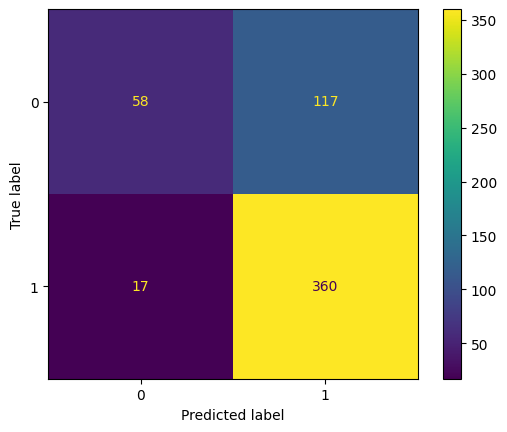

In [1112]:
evaluate_model(best_model,X_train,y_train)

              precision    recall  f1-score   support

           0       0.25      0.06      0.10        17
           1       0.72      0.93      0.82        45

    accuracy                           0.69        62
   macro avg       0.49      0.50      0.46        62
weighted avg       0.59      0.69      0.62        62



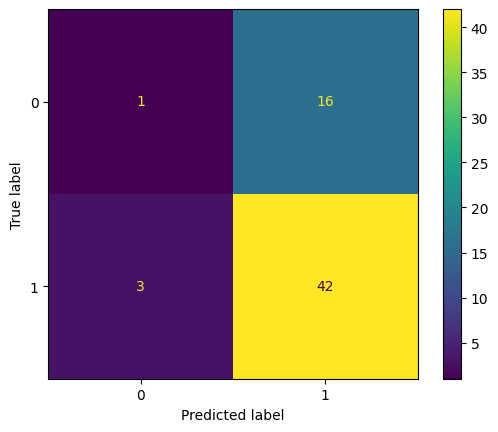

In [1113]:
evaluate_model(best_model,X_test,y_test)